In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# set font size
mpl.rcParams.update({'font.size': 8})

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

In [2]:
nerd_sqlite = '../../Core_nerd_analysis/nerd.sqlite'

db_path = Path(nerd_sqlite).expanduser().resolve()
if not db_path.exists():
    raise FileNotFoundError(f"Database not found: {db_path}")

conn = sqlite3.connect(db_path)
conn.row_factory = sqlite3.Row

def read_sql(query: str, params: dict | None = None) -> pd.DataFrame:
    """Run a SQL query against the configured database and return a DataFrame."""
    return pd.read_sql_query(query, conn, params=params or {})

In [3]:
# Load all fit parameters for round3_constrained modrate fits
fit_params_df = read_sql(
    """
    WITH run AS (
        SELECT
            r.id  AS fit_run_id,
            r.rg_id,
            mn.site,
            UPPER(mn.base) AS base
        FROM probe_tc_fit_runs r
        JOIN meta_nucleotides mn ON mn.id = r.nt_id
        WHERE r.fit_kind = 'round3_constrained'
          AND r.valtype  = 'modrate'
    )
    SELECT
        r.rg_id,
        r.site,
        r.base,
        MIN(pr.temperature) AS temperature,
        MIN(pr.buffer_id)      AS buffer,
        MAX(mc.disp_name)   AS disp_name,

        MAX(CASE WHEN p.param_name IN ('log_kobs','logkobs')
                 THEN p.param_numeric END) AS log_kobs,
        MAX(CASE WHEN p.param_name IN ('log_kdeg','logkdeg')
                 THEN p.param_numeric END) AS log_kdeg,
        MAX(CASE WHEN p.param_name IN ('log_kobs_err','logkobs_err')
                 THEN p.param_numeric END) AS log_kobs_err,
        MAX(CASE WHEN p.param_name IN ('log_kdeg_err','logkdeg_err')
                 THEN p.param_numeric END) AS log_kdeg_err,
        MAX(CASE WHEN p.param_name = 'diag:r2'
                 THEN p.param_numeric END) AS diag_r2

    FROM probe_tc_fit_params p
    JOIN run r              ON r.fit_run_id = p.fit_run_id
    JOIN probe_reactions pr ON pr.rg_id      = r.rg_id
    JOIN meta_constructs mc ON mc.id         = pr.construct_id

    GROUP BY r.fit_run_id, r.rg_id, r.site, r.base
    """
    )

# Preprocess k_vals to get k_add-like values
fit_params_df.loc[:, 'inv_temp'] = 1/(273.15 + fit_params_df['temperature'])
conc_DMS = 0.015852692  # in M, 1.5% v/v
# log_kobs in nerd is kappa for now, need to correct later
# new log_kobs below is K/K+1 kadd [P]_0
fit_params_df.loc[:, 'log_kobs'] = fit_params_df['log_kobs'] + fit_params_df['log_kdeg']

In [4]:
fit_params_df = fit_params_df[(fit_params_df['disp_name'].str.contains('p4p6_wt_nobc'))]
fit_params_df

,rg_id,site,base,temperature,buffer,disp_name,log_kobs,log_kdeg,log_kobs_err,log_kdeg_err,diag_r2,inv_temp
4059,123,102,G,23.0,2,p4p6_wt_nobc,NaN,NaN,NaN,NaN,NaN,0.003377
4060,123,103,G,23.0,2,p4p6_wt_nobc,-15.391738,-8.067974,0.296183,0.0,0.487337,0.003377
4061,123,104,A,23.0,2,p4p6_wt_nobc,-11.843255,-8.067974,0.039808,0.0,0.981779,0.003377
4062,123,105,A,23.0,2,p4p6_wt_nobc,-12.115099,-8.067974,0.045539,0.0,0.976153,0.003377
4063,123,106,U,23.0,2,p4p6_wt_nobc,-15.051515,-8.067974,0.267403,0.0,0.538394,0.003377
...,...,...,...,...,...,...,...,...,...,...,...,...
4718,130,263,C,23.0,3,p4p6_wt_nobc,-13.859980,-8.181574,0.234228,0.0,0.785306,0.003377
4719,130,264,C,23.0,3,p4p6_wt_nobc,-15.035101,-8.181574,0.634883,0.0,0.331875,0.003377
4720,130,265,A,23.0,3,p4p6_wt_nobc,-13.942986,-8.181574,0.165945,0.0,0.879327,0.003377
4721,130,266,A,23.0,3,p4p6_wt_nobc,-13.858719,-8.181574,0.197353,0.0,0.837461,0.003377


In [5]:
def barplot_fmod_values(selected_fmod_run_id, selected_valtype=None, selected_sample=None):
    """Generate bar plots of fmod values for a given probe_fmod_run ID."""
    data = read_sql(
        """
        SELECT
            fv.fmod_run_id,
            fv.valtype,
            fv.fmod_val,
            s.sample_name,
            mn.site,
            mn.base,
            mn.site || '_' || UPPER(mn.base) AS site_base
        FROM probe_fmod_values fv
        JOIN probe_reactions pr ON pr.id = fv.rxn_id
        JOIN sequencing_samples s ON s.id = pr.s_id
        JOIN meta_nucleotides mn ON mn.id = fv.nt_id
        WHERE fv.fmod_run_id = :run_id
        ORDER BY s.sample_name, mn.site
        """,
        {"run_id": selected_fmod_run_id},
    )

    if data.empty:
        print("No mutation-rate rows found for that run id.")
    else:
        if selected_valtype:
            data = data[data["valtype"] == selected_valtype]
        if selected_sample:
            data = data[data["sample_name"] == selected_sample]

        if data.empty:
            print("Filters removed all rows. Adjust selections.")
        else:
            summary = (
                data.groupby(["sample_name", "site_base"], as_index=False)["fmod_val"].mean()
            )
            fig, ax = plt.subplots(figsize=(8, 3))
            for sample, group in summary.groupby("sample_name"):
                group_sorted = group.sort_values("site_base")
                ax.bar(
                    group_sorted["site_base"],
                    group_sorted["fmod_val"],
                    label=sample,
                    alpha=0.6,
                )
            ax.set_title(
                f"Probe mutation rates for run {selected_fmod_run_id}"
                + (f" – {selected_valtype}" if selected_valtype else "")
            )
            ax.set_xlabel("Sequence (site_base)")
            ax.set_ylabel(r'$f_{\text{mod}}$')
            ax.legend(loc="upper right")
            plt.setp(ax.get_xticklabels(), rotation=90)
            plt.tight_layout()

In [13]:
def fetch_p4p6_replicate(rg_id):
    """
    Fetch and process fmod values for p4p6 replicate experiments.
    Performs background subtraction between two probe concentrations.
    """

    data = read_sql(
        """
        SELECT
            pr.probe_concentration,
            fv.fmod_val,
            s.sample_name,
            mn.site,
            mn.base,
            mn.site || '_' || UPPER(mn.base) AS site_base
        FROM probe_fmod_values fv
        JOIN probe_reactions pr ON pr.id = fv.rxn_id
        JOIN sequencing_samples s ON s.id = pr.s_id
        JOIN meta_nucleotides mn ON mn.id = fv.nt_id
        WHERE pr.rg_id = :rg_id
        AND fv.valtype = 'modrate'
        AND pr.rt_protocol = 'MRT'
        AND fmod_val > 0.0
        ORDER BY s.sample_name, mn.site
        """,
        {"rg_id": rg_id},
    )

    concs = data["probe_concentration"].unique()
    data_0 = data[data["probe_concentration"] == concs[0]]
    data_1 = data[data["probe_concentration"] == concs[2]]

    merged = pd.merge(data_0, data_1, on=['site','base','site_base'], suffixes=('_0', '_1'))

    # bkg subtraction
    merged['fmod_val'] = merged['fmod_val_1'] - merged['fmod_val_0']
    merged = merged[['site', 'base', 'fmod_val']]
    # set negative values to 0.0
    merged.loc[merged['fmod_val'] < 0.0, 'fmod_val'] = 0.0

    return merged

In [14]:

def plot_rep_v_tc(rep_v_tc, title_suffix):

    # filter to greater than -20 and drop infinity or na
    rep_v_tc_filt = rep_v_tc[(rep_v_tc['log_kobs_timecourse'] > -20) & (rep_v_tc['log_kobs_replicate'] > -20)].replace([np.inf, -np.inf], np.nan).dropna()

    # calculate R2 wrt y=x
    residuals = rep_v_tc_filt['log_kobs_replicate'] - rep_v_tc_filt['log_kobs_timecourse']
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((rep_v_tc_filt['log_kobs_replicate'] - rep_v_tc_filt['log_kobs_replicate'].mean())**2)
    r_squared = 1 - (ss_res / ss_tot)
    

    # mark outliers as a new column in rep_v_tc
    rep_v_tc['is_outlier'] = rep_v_tc['log_kobs_timecourse'] < -20

    fig, ax = plt.subplots(figsize=(3, 3))
    sns.scatterplot(
        data=rep_v_tc,
        x='log_kobs_timecourse',
        y='log_kobs_replicate',
        hue = 'is_outlier',
        palette={False: 'black', True: 'gray'},
        legend=False,
        s=12,
        ax=ax
    )

    ax.set_xlabel(r'$\ln(k_{obs,j})$ from time-course')
    ax.set_ylabel(r'$\ln(k_{obs,j})$ from endpt. replicate')

    # y = x line
    x_vals = np.array(ax.get_xlim())
    ax.plot(x_vals, x_vals, '-', color='darkred', linewidth=1)

    # annotate pearson R (bottom left)
    ax.text(
        -17.5,
        -10.5,
        rf'$R^2$ = {r_squared:.2f}',
        fontsize=9,
        color='darkred'
    )

    ax.set_ylim(-18, -10)

    # ---- inset ----
    axins = inset_axes(
        ax,
        width="40%",   # % of parent axes
        height="40%",
        loc="upper left",
        bbox_to_anchor=(0.15, -0.01, 1, 1),  # ← shift right
        bbox_transform=ax.transAxes,
        borderpad=0.8
    )

    sns.scatterplot(
        data=rep_v_tc,
        x='log_kobs_timecourse',
        y='log_kobs_replicate',
        color='black',
        s=12,
        ax=axins
    )

    # same y = x line in inset
    x_vals_ins = np.array(axins.get_xlim())
    axins.plot(x_vals_ins, x_vals_ins, '-', color='darkred', linewidth=1)

    # zoom region (adjust as needed)
    axins.set_xlim(-18, -10)
    axins.set_ylim(-18, -10)

    # remove axins labels axes
    axins.set_xlabel('')
    axins.set_ylabel('')

    plt.tight_layout()
    plt.savefig(f'P4P6_rep_vs_timecourse_{title_suffix}.pdf')

In [16]:
# fetch replicate data
p4p6_rep_NoMg = fetch_p4p6_replicate(127) # No Mg rep1
p4p6_rep_NoMg_2 = fetch_p4p6_replicate(128)   # No Mg rep2

# get kdeg from time-course with matching condition
p4p6_tc_NoMg = fit_params_df[fit_params_df['buffer'] == 2]
mean_logkdeg = p4p6_tc_NoMg['log_kdeg'].unique()[1:].mean()
kdeg_noMg = np.exp(mean_logkdeg)

# mean per site and base
p4p6_tc_NoMg = p4p6_tc_NoMg.groupby(['site', 'base'], as_index=False)['log_kobs'].mean()

# transformation to get kobs
p4p6_rep_NoMg['kobs'] = -np.log(1 - p4p6_rep_NoMg['fmod_val']) * kdeg_noMg
p4p6_rep_NoMg['log_kobs'] = np.log(p4p6_rep_NoMg['kobs'])

p4p6_rep_NoMg_2['kobs'] = -np.log(1 - p4p6_rep_NoMg_2['fmod_val']) * kdeg_noMg
p4p6_rep_NoMg_2['log_kobs'] = np.log(p4p6_rep_NoMg_2['kobs'])

/opt/homebrew/Caskroom/miniforge/base/envs/data_analysis/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/data_analysis/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_96982/2186343352.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_96982/2186343352.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


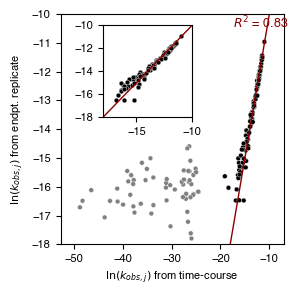

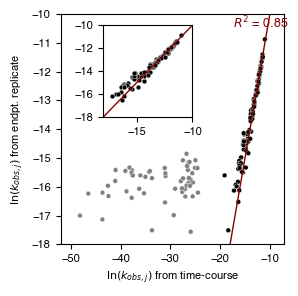

In [17]:
# merge for plotting
rep_v_tc_NoMg = pd.merge(
    p4p6_rep_NoMg,
    p4p6_tc_NoMg,
    on=['site', 'base'],
    suffixes=('_replicate', '_timecourse')
)

rep_v_tc_NoMg_2 = pd.merge(
    p4p6_rep_NoMg_2,
    p4p6_tc_NoMg,
    on=['site', 'base'],
    suffixes=('_replicate', '_timecourse')
)

# plot
plot_rep_v_tc(rep_v_tc_NoMg, 'NoMg')
plot_rep_v_tc(rep_v_tc_NoMg_2, 'NoMg_2')
